In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib

# Train a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import os
os.chdir('/workspace') # change to the root directory of the project

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [3]:
# Load the normalized MSI data
# peaks = pd.read_pickle(f"{path}peaks_standardized_lesion.pkl")
# pixels = pd.read_pickle(f"{path}pixels_filtered_lesion.pkl")
# peaks = pd.read_pickle(f"{path}peaks_standardized.pkl")
# peaks = pd.read_pickle(f"{path}peaks_filtered.pkl")
hes_features = pd.read_pickle(f"data/MALDI_IHC/hes_features.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

In [4]:
# Filter the features
hes_features = hes_features.loc[pixels.Id]
hes_features.reset_index(drop=True, inplace=True)

hes_features.shape, pixels.shape

((6104831, 1536), (6104831, 15))

# Remove the unwanted sildes

In [5]:
# list of unwanted slides
bad_lames = ['13AG03225-06', '13AG06573-10', '544085-14', '546332-17', '549724-18', '549724-19', '549764-29', '549857-19', '549857-22', '552138-25']

# Remove the bad samples
hes_features = hes_features[~pixels['run'].isin(bad_lames)]
pixels = pixels[~pixels['run'].isin(bad_lames)]

In [6]:
# Exclude the pixels with defects
hes_features = hes_features[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
hes_features.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

# Define the densities and a threshold for each pixel density

In [7]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

In [8]:
# load the predicted pixels
pixels_cd8 = pd.read_pickle(f"{path_results}pixels_CD8.pkl")

hes_features.shape, pixels_cd8.shape

((4460219, 1536), (4460219, 20))

# Split the data into training and testing sets

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hes_features[pixels_cd8['Density_Lesion'] > 0.5],
                                                    pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Density_CD8'],
                                                    test_size=0.05,
                                                    random_state=42)

# Train a linear regression model

In [ ]:
# Create a linear regression model
model_linear_reg = LinearRegression()

# Fit the model to the training data
model_linear_reg.fit(X_train, y_train)

LinearRegression()

R-squared (Train): 0.27
R-squared (Test): 0.27
Mean Squared Error (Train): 3.67e-04
Mean Squared Error (Test): 3.54e-04


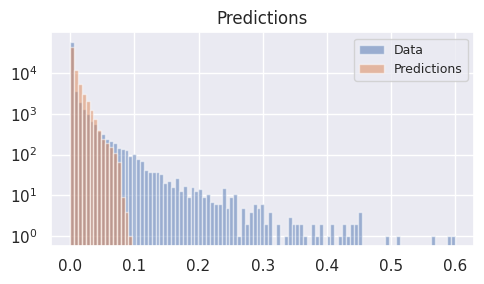

In [14]:
# Make predictions
y_pred_train = model_linear_reg.predict(X_train)
y_pred_test = model_linear_reg.predict(X_test)

# Clip the predictions between 0 and 1
y_pred_train = np.clip(y_pred_train, 0, 1)
y_pred_test = np.clip(y_pred_test, 0, 1)

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

In [20]:
# Save the model
joblib.dump(model_linear_reg, f"{path_models}linear_regressor_HES_Density_CD8.joblib")

['data/MALDI_IHC/correlations/results/models/linear_regressor_HES_Density_CD8.joblib']

# Perform the training of the xgboost model

In [12]:
# Convert the data into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
# Define XGBoost regressor parameters
params = {'objective':'reg:squarederror',
          'max_depth':12,
          'learning_rate':0.1,
          'alpha':100,
          'colsample_bytree':0.9,
          'scale_pos_weight':float(np.sum(pixels['Density_CD8'] < threshold['Density_CD8']) / np.sum(pixels['Density_CD8'] > threshold['Density_CD8'])),
          'device':"cpu"}

# Initialize the evals_result dictionary
evals_result = {}

# Train the model with evals_result to store the evaluation results
model_reg = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10,
                      evals_result=evals_result)

[0]	train-rmse:0.02197	test-rmse:0.02158
[1]	train-rmse:0.02158	test-rmse:0.02120
[2]	train-rmse:0.02125	test-rmse:0.02087
[3]	train-rmse:0.02095	test-rmse:0.02060
[4]	train-rmse:0.02069	test-rmse:0.02035
[5]	train-rmse:0.02046	test-rmse:0.02013
[6]	train-rmse:0.02026	test-rmse:0.01993
[7]	train-rmse:0.02007	test-rmse:0.01975
[8]	train-rmse:0.01989	test-rmse:0.01959
[9]	train-rmse:0.01973	test-rmse:0.01944
[10]	train-rmse:0.01959	test-rmse:0.01931
[11]	train-rmse:0.01946	test-rmse:0.01920
[12]	train-rmse:0.01934	test-rmse:0.01909
[13]	train-rmse:0.01923	test-rmse:0.01900
[14]	train-rmse:0.01914	test-rmse:0.01891
[15]	train-rmse:0.01905	test-rmse:0.01883
[16]	train-rmse:0.01896	test-rmse:0.01875
[17]	train-rmse:0.01889	test-rmse:0.01868
[18]	train-rmse:0.01882	test-rmse:0.01862
[19]	train-rmse:0.01875	test-rmse:0.01856
[20]	train-rmse:0.01869	test-rmse:0.01851
[21]	train-rmse:0.01863	test-rmse:0.01845
[22]	train-rmse:0.01857	test-rmse:0.01841
[23]	train-rmse:0.01852	test-rmse:0.01836
[2

In [ ]:
# Save the model
joblib.dump(model_reg, f"{path_models}xgb_regressor_HES_Density_CD8.joblib")

['data/MALDI_IHC/correlations/results/models/xgb_regressor_HES_Density_CD8.joblib']

R-squared (Train): 0.42
R-squared (Test): 0.38
Mean Squared Error (Train): 2.93e-04
Mean Squared Error (Test): 2.98e-04


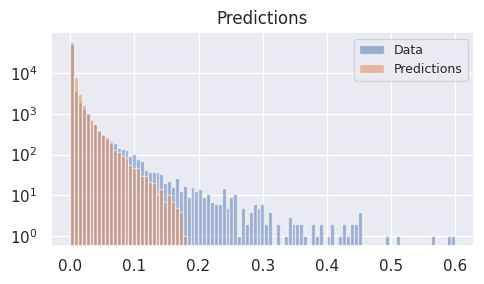

In [15]:
# Make predictions
y_pred_train = model_reg.predict(dtrain)
y_pred_test = model_reg.predict(dtest)

# Clip the predictions between 0 and 1
y_pred_train = np.clip(y_pred_train, 0, 1)
y_pred_test = np.clip(y_pred_test, 0, 1)

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

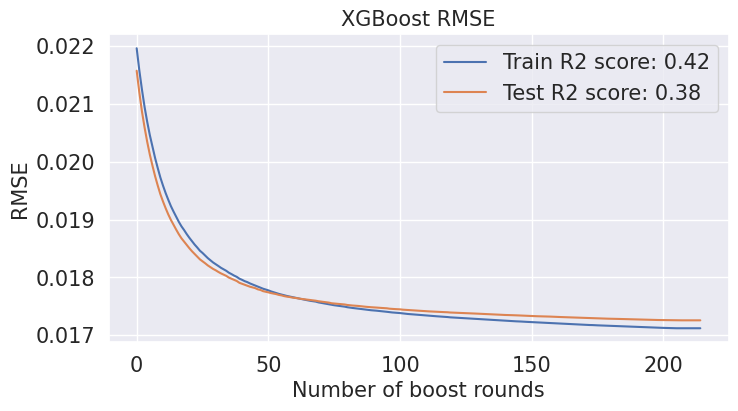

In [16]:
# Plot the training and validation metrics
plt.figure(figsize=(8, 4))
plt.plot(evals_result['train']['rmse'], label=f'Train R2 score: {r2_train:.2f}')
plt.plot(evals_result['test']['rmse'], label=f'Test R2 score: {r2_test:.2f}')
plt.legend(fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.xlabel('Number of boost rounds', fontsize=15)
plt.title('XGBoost RMSE', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

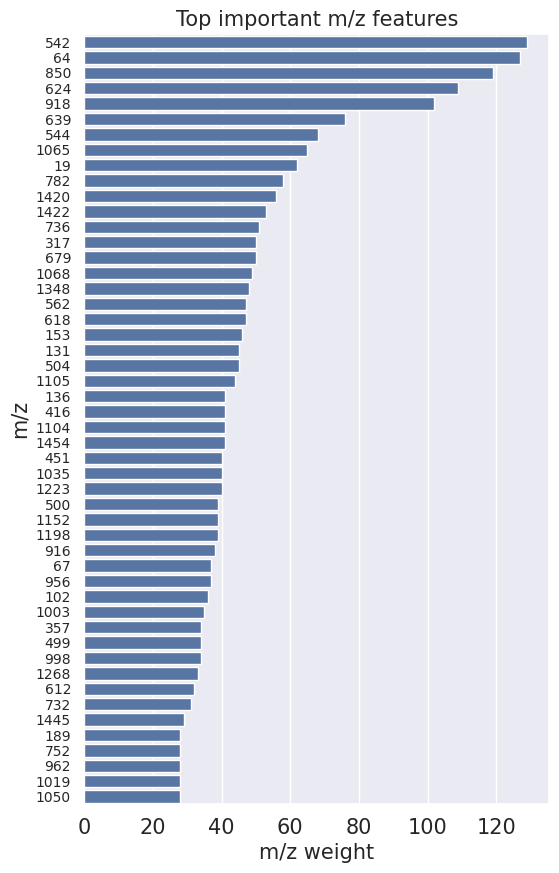

In [17]:
 # Compute the feature importance
feature_importance_reg = model_reg.get_score(importance_type='weight')

# Sort the feature importance
feature_importance_reg = dict(sorted(feature_importance_reg.items(), key=lambda item: item[1], reverse=True))

# Plot the top important features
plt.figure(figsize=(6, 10))
sns.barplot(x=list(feature_importance_reg.values())[:50], y=list(feature_importance_reg.keys())[:50])
plt.title('Top important m/z features', fontsize=15)
plt.xlabel('m/z weight', fontsize=15)
plt.ylabel('m/z', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
plt.show()

# Repeat the process for the pedicted densities

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hes_features[pixels_cd8['Density_Lesion'] > 0.5],
                                                    pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Predicted_CD8_without_tumor'],
                                                    test_size=0.05,
                                                    random_state=42)

# Train a linear regression model

In [17]:
# Create a linear regression model
model_linear_reg_pred = LinearRegression()

# Fit the model to the training data
model_linear_reg_pred.fit(X_train, y_train)

LinearRegression()

R-squared (Train): 0.48
R-squared (Test): 0.48
Mean Squared Error (Train): 6.04e-05
Mean Squared Error (Test): 6.10e-05


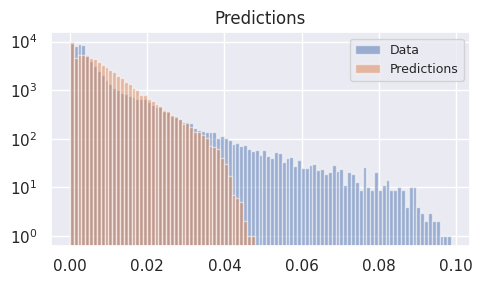

In [18]:
# Make predictions
y_pred_train = model_linear_reg_pred.predict(X_train)
y_pred_test = model_linear_reg_pred.predict(X_test)

# Clip the predictions between 0 and 1
y_pred_train = np.clip(y_pred_train, 0, 1)
y_pred_test = np.clip(y_pred_test, 0, 1)

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

In [19]:
# Save the model
joblib.dump(model_linear_reg_pred, f"{path_models}linear_regressor_HES_Predicted_CD8.joblib")

['data/MALDI_IHC/correlations/results/models/linear_regressor_HES_Predicted_CD8.joblib']

# Perform the training of the xgboost model

In [19]:
# Convert the data into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
# Define XGBoost regressor parameters
params = {'objective':'reg:squarederror',
          'max_depth':12,
          'learning_rate':0.1,
          'alpha':100,
          'colsample_bytree':0.9,
          'scale_pos_weight':float(np.sum(pixels['Density_CD8'] < threshold['Density_CD8']) / np.sum(pixels['Density_CD8'] > threshold['Density_CD8'])),
          'device':"cpu"}

# Initialize the evals_result dictionary
evals_result = {}

# Train the model with evals_result to store the evaluation results
model_reg_pred = xgb.train(params=params,
                           dtrain=dtrain,
                           num_boost_round=1000,
                           evals=[(dtrain, 'train'), (dtest, 'test')],
                           early_stopping_rounds=10,
                           evals_result=evals_result)

[0]	train-rmse:0.01042	test-rmse:0.01046
[1]	train-rmse:0.01012	test-rmse:0.01016
[2]	train-rmse:0.00986	test-rmse:0.00991
[3]	train-rmse:0.00964	test-rmse:0.00968
[4]	train-rmse:0.00943	test-rmse:0.00948
[5]	train-rmse:0.00926	test-rmse:0.00930
[6]	train-rmse:0.00910	test-rmse:0.00914
[7]	train-rmse:0.00896	test-rmse:0.00900
[8]	train-rmse:0.00883	test-rmse:0.00887
[9]	train-rmse:0.00870	test-rmse:0.00875
[10]	train-rmse:0.00860	test-rmse:0.00865
[11]	train-rmse:0.00850	test-rmse:0.00855
[12]	train-rmse:0.00841	test-rmse:0.00846
[13]	train-rmse:0.00833	test-rmse:0.00839
[14]	train-rmse:0.00826	test-rmse:0.00831
[15]	train-rmse:0.00820	test-rmse:0.00825
[16]	train-rmse:0.00814	test-rmse:0.00820
[17]	train-rmse:0.00808	test-rmse:0.00814
[18]	train-rmse:0.00803	test-rmse:0.00809
[19]	train-rmse:0.00799	test-rmse:0.00805
[20]	train-rmse:0.00794	test-rmse:0.00800
[21]	train-rmse:0.00789	test-rmse:0.00796
[22]	train-rmse:0.00786	test-rmse:0.00792
[23]	train-rmse:0.00782	test-rmse:0.00789
[2

In [ ]:
# Save the model
joblib.dump(model_reg_pred, f"{path_models}xgb_regressor_HES_Predicted_CD8.joblib")

['data/MALDI_IHC/correlations/results/models/xgb_regressor_HES_Predicted_CD8.joblib']

R-squared (Train): 0.56
R-squared (Test): 0.55
Mean Squared Error (Train): 5.12e-05
Mean Squared Error (Test): 5.26e-05


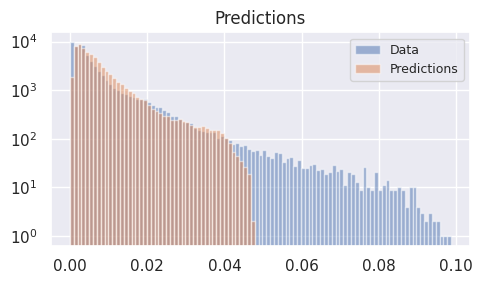

In [ ]:
# Make predictions
y_pred_train = model_reg_pred.predict(dtrain)
y_pred_test = model_reg_pred.predict(dtest)

# Clip the predictions between 0 and 1
y_pred_train = np.clip(y_pred_train, 0, 1)
y_pred_test = np.clip(y_pred_test, 0, 1)

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

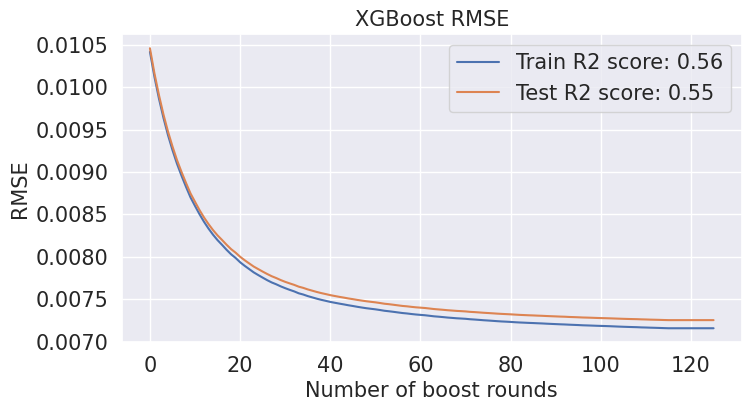

In [23]:
# Plot the training and validation metrics
plt.figure(figsize=(8, 4))
plt.plot(evals_result['train']['rmse'], label=f'Train R2 score: {r2_train:.2f}')
plt.plot(evals_result['test']['rmse'], label=f'Test R2 score: {r2_test:.2f}')
plt.legend(fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.xlabel('Number of boost rounds', fontsize=15)
plt.title('XGBoost RMSE', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

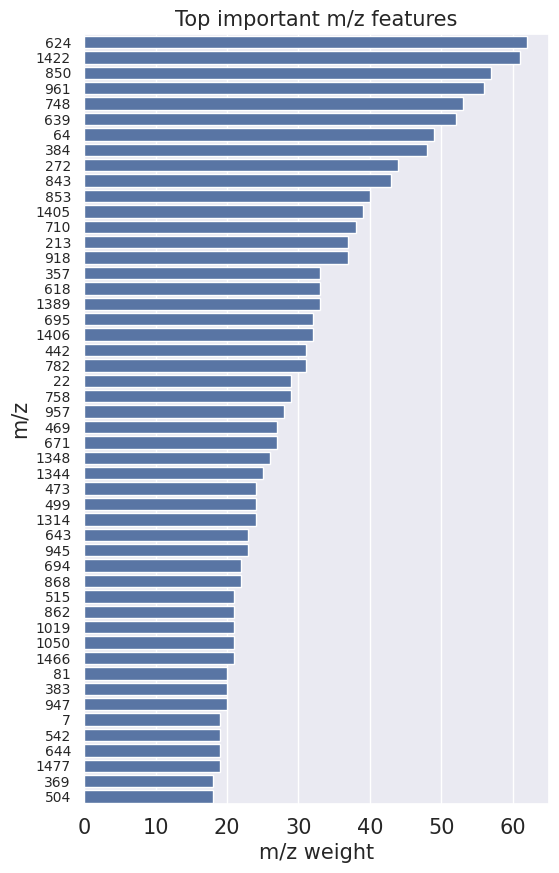

In [24]:
 # Compute the feature importance
feature_importance_reg = model_reg_pred.get_score(importance_type='weight')

# Sort the feature importance
feature_importance_reg = dict(sorted(feature_importance_reg.items(), key=lambda item: item[1], reverse=True))

# Plot the top important features
plt.figure(figsize=(6, 10))
sns.barplot(x=list(feature_importance_reg.values())[:50], y=list(feature_importance_reg.keys())[:50])
plt.title('Top important m/z features', fontsize=15)
plt.xlabel('m/z weight', fontsize=15)
plt.ylabel('m/z', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
plt.show()

# Perform the predictions on the entire dataset

In [21]:
# Load the models
model_reg = joblib.load(f"{path_models}xgb_regressor_HES_Density_CD8.joblib")
model_reg_pred = joblib.load(f"{path_models}xgb_regressor_HES_Predicted_CD8.joblib")

In [22]:
# Load all the features
dall = xgb.DMatrix(hes_features, label=pixels['Density_CD8'])

In [25]:
# Apply the weights to the peaks
pixels_cd8['Lin_HES_Density_CD8'] = np.clip(model_linear_reg.predict(hes_features), 0, 1)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Density_CD8'],
                                          pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Lin_HES_Density_CD8'])[0, 1]:.2f}")

Pearson correlation: 0.52


In [27]:
# Apply the weights to the peaks
pixels_cd8['XGB_HES_Density_CD8'] = np.clip(model_reg.predict(dall), 0, 1)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Density_CD8'],
                                          pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['XGB_HES_Density_CD8'])[0, 1]:.2f}")

Pearson correlation: 0.65


In [32]:
# Apply the weights to the peaks
pixels_cd8['Lin_HES_Predicted_CD8'] = np.clip(model_linear_reg_pred.predict(hes_features), 0, 1)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Predicted_CD8_without_tumor'],
                                          pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Lin_HES_Predicted_CD8'])[0, 1]:.2f}")

Pearson correlation: 0.69


In [33]:
# Apply the weights to the peaks
pixels_cd8['XGB_HES_Predicted_CD8'] = np.clip(model_reg_pred.predict(dall), 0, 1)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['Predicted_CD8_without_tumor'],
                                          pixels_cd8[pixels_cd8['Density_Lesion'] > 0.5]['XGB_HES_Predicted_CD8'])[0, 1]:.2f}")

Pearson correlation: 0.75


In [34]:
predictions = ['Density_CD8', 'XGB_HES_Density_CD8', 'Lin_HES_Density_CD8', 'Predicted_CD8_without_tumor', 'XGB_HES_Predicted_CD8', 'Lin_HES_Predicted_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=len(predictions), figsize=(50, 200), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels_cd8[pixels_cd8['run'] == lame]
    pixels_lame = pixels_lame[pixels_lame['Density_Lesion'] > 0.5]
    for j, prediction in enumerate(predictions):
        # Create a pivot table for imshow
        heatmap_data = pixels_lame.pivot(index='y', columns='x', values=prediction)
        
        # Display the heatmap
        im = axs[i, j].imshow(heatmap_data, cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99), origin='upper')
        fig.colorbar(im, ax=axs[i, j])
        
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.savefig(f"{path_results}XGB_HES_CD8_lesion.png")
plt.close()

In [35]:
predictions = ['Density_CD8', 'XGB_HES_Density_CD8', 'Lin_HES_Density_CD8', 'Predicted_CD8_without_tumor', 'XGB_HES_Predicted_CD8', 'Lin_HES_Predicted_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=len(predictions), figsize=(50, 200), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels_cd8[pixels_cd8['run'] == lame]
    for j, prediction in enumerate(predictions):
        # Create a pivot table for imshow
        heatmap_data = pixels_lame.pivot(index='y', columns='x', values=prediction)
        
        # Display the heatmap
        im = axs[i, j].imshow(heatmap_data, cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99), origin='upper')
        fig.colorbar(im, ax=axs[i, j])
        
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.savefig(f"{path_results}XGB_HES_CD8.png")
plt.close()